# Demo Workflow & Decoupler
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc
from rapids_singlecell.cunnData import cunnData

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 2.54 s, sys: 191 ms, total: 2.73 s
Wall time: 2.73 s


In [5]:
%%time
cudata = cunnData(adata=adata)

CPU times: user 65.1 ms, sys: 295 ms, total: 360 ms
Wall time: 359 ms


In [6]:
cudata.nnz

114212920

In [7]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 3.1087355613708496


## Preprocessing

In [8]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [9]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 7.11 ms, sys: 0 ns, total: 7.11 ms
Wall time: 6.97 ms


In [10]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 6 ms, sys: 588 µs, total: 6.59 ms
Wall time: 6.48 ms


In [11]:
%%time
rsc.pp.calculate_qc_metrics(cudata,qc_vars=["MT","RIBO"])

CPU times: user 105 ms, sys: 0 ns, total: 105 ms
Wall time: 105 ms


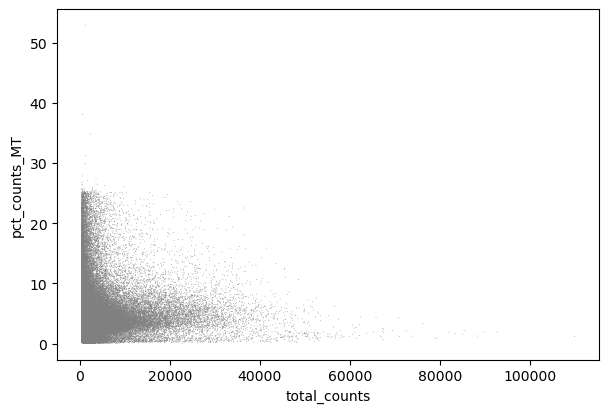

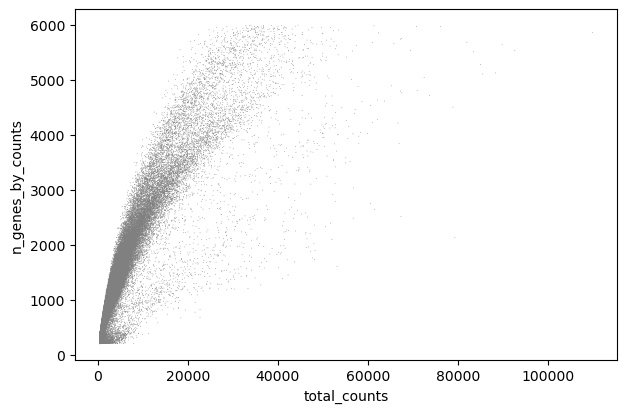

In [12]:
sc.pl.scatter(cudata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(cudata, x='total_counts', y='n_genes_by_counts')

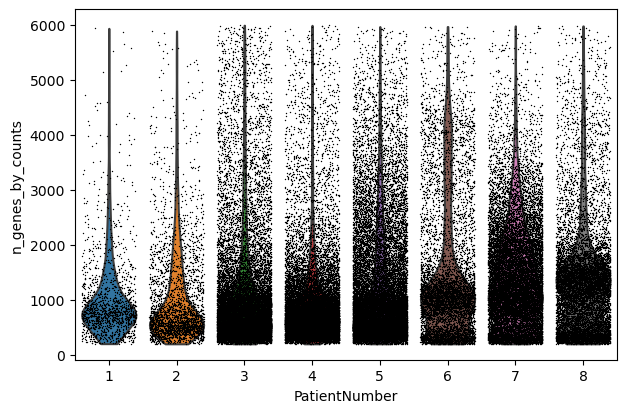

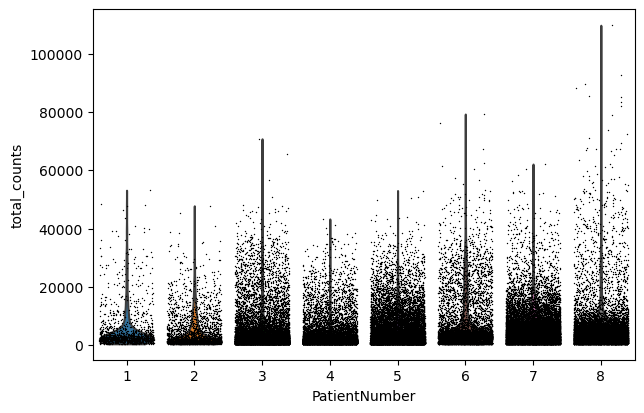

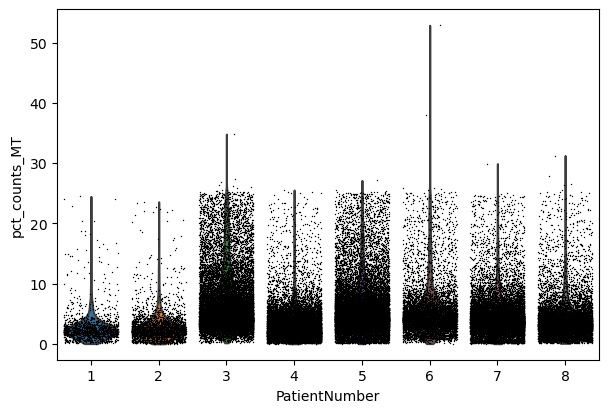

In [13]:
sc.pl.violin(cudata, 'n_genes_by_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(cudata, 'total_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(cudata, 'pct_counts_MT',jitter=0.4, groupby="PatientNumber")


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [14]:
%%time
cudata = cudata[cudata.obs["n_genes_by_counts"] < 5000]
cudata = cudata[cudata.obs["pct_counts_MT"] < 20]

CPU times: user 125 ms, sys: 40.6 ms, total: 165 ms
Wall time: 165 ms


We also filter out genes that are expressed in less than 3 cells.

In [15]:
%%time
rsc.pp.filter_genes(cudata,min_count=3)

filtered out 8034 genes based on n_cells_by_counts
CPU times: user 69.1 ms, sys: 32.7 ms, total: 102 ms
Wall time: 101 ms


The size of our count matrix is now reduced.

In [16]:
cudata.shape

(91068, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [17]:
%%time
rsc.pp.normalize_total(cudata,target_sum=1e4)

CPU times: user 7.54 ms, sys: 3.32 ms, total: 10.9 ms
Wall time: 10.5 ms


Next, we data transform the count matrix.

In [18]:
%%time
rsc.pp.log1p(cudata)

CPU times: user 1.7 ms, sys: 13 ms, total: 14.7 ms
Wall time: 13.7 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `cell_ranger` for selecting highly variable genes based on the log normalized counts in `.X`

In [19]:
%%time
rsc.pp.highly_variable_genes(cudata,n_top_genes=5000,flavor="cell_ranger")

CPU times: user 255 ms, sys: 5.28 ms, total: 260 ms
Wall time: 259 ms


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [20]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 135 ms, sys: 65.8 ms, total: 201 ms
Wall time: 200 ms


Now we restrict our cunndata object to the highly variable genes.

In [21]:
%%time
rsc.pp.filter_highly_variable(cudata)

CPU times: user 47.9 ms, sys: 14.9 ms, total: 62.8 ms
Wall time: 62.3 ms


Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [22]:
%%time
rsc.pp.regress_out(cudata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 595 ms, sys: 663 ms, total: 1.26 s
Wall time: 1.26 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [23]:
%%time
rsc.pp.scale(cudata,max_value=10)

CPU times: user 51.8 ms, sys: 14.8 ms, total: 66.6 ms
Wall time: 65.6 ms


Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [24]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 201 ms, sys: 121 ms, total: 321 ms
Wall time: 321 ms


In [25]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 4.4699273109436035


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuMLs.

In [26]:
%%time
rsc.tl.pca(adata, n_comps = 100)

CPU times: user 1.4 s, sys: 731 ms, total: 2.13 s
Wall time: 2.13 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

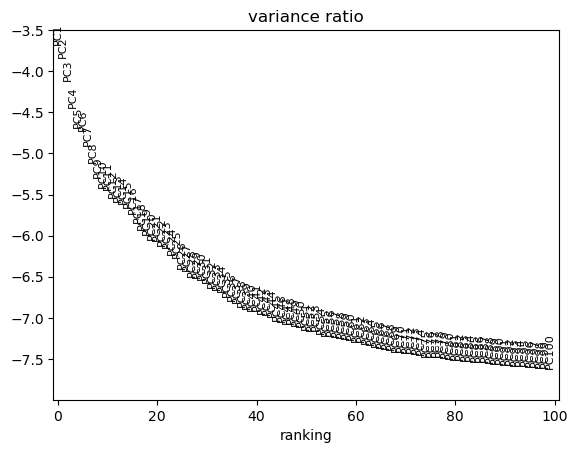

In [27]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [28]:
%%time
rsc.tl.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 277 ms, sys: 56.7 ms, total: 334 ms
Wall time: 333 ms


Next we calculate the UMAP embedding using rapdis.

In [29]:
%%time
rsc.tl.umap(adata)

CPU times: user 377 ms, sys: 24 ms, total: 401 ms
Wall time: 400 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [30]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 264 ms, sys: 383 ms, total: 647 ms
Wall time: 648 ms


In [31]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 233 ms, sys: 389 ms, total: 623 ms
Wall time: 622 ms


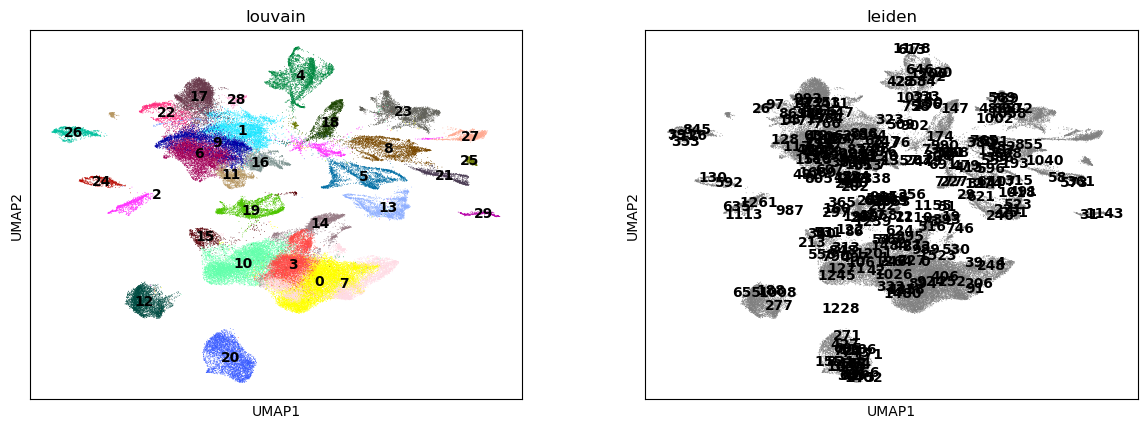

CPU times: user 870 ms, sys: 122 ms, total: 992 ms
Wall time: 849 ms


In [32]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

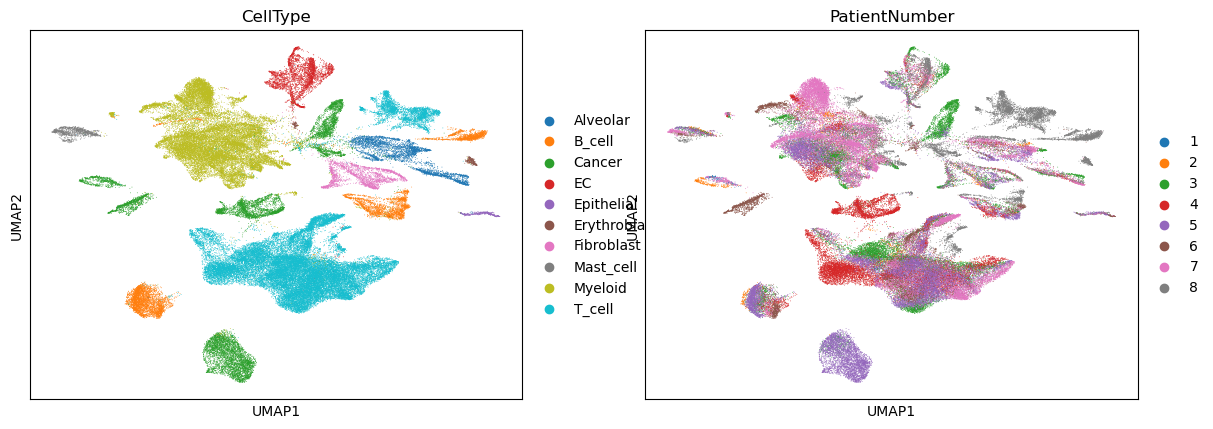

In [33]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [34]:
%%time
rsc.tl.tsne(adata, n_pcs = 40,perplexity=30,early_exaggeration=12, learning_rate=200)

[W] [13:47:13.803034] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 925 ms, sys: 804 ms, total: 1.73 s
Wall time: 1.72 s


In [35]:
rsc.tl.kmeans(adata, n_clusters=8)

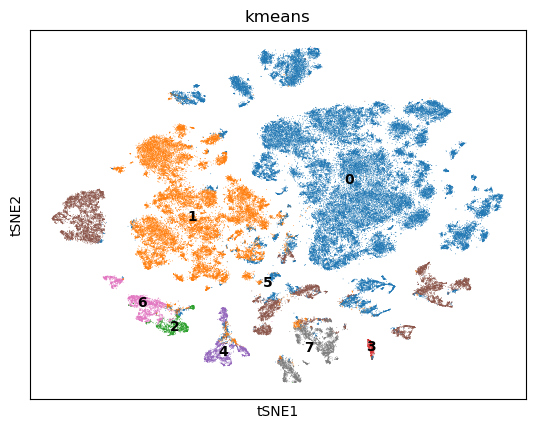

CPU times: user 488 ms, sys: 146 ms, total: 634 ms
Wall time: 490 ms


In [36]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

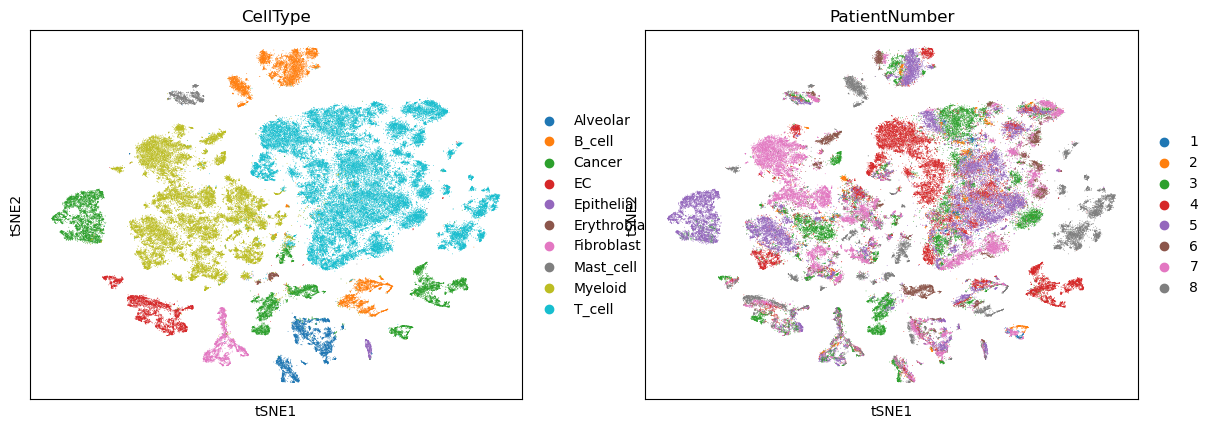

In [37]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [38]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 2.78 s, sys: 606 ms, total: 3.39 s
Wall time: 3.38 s


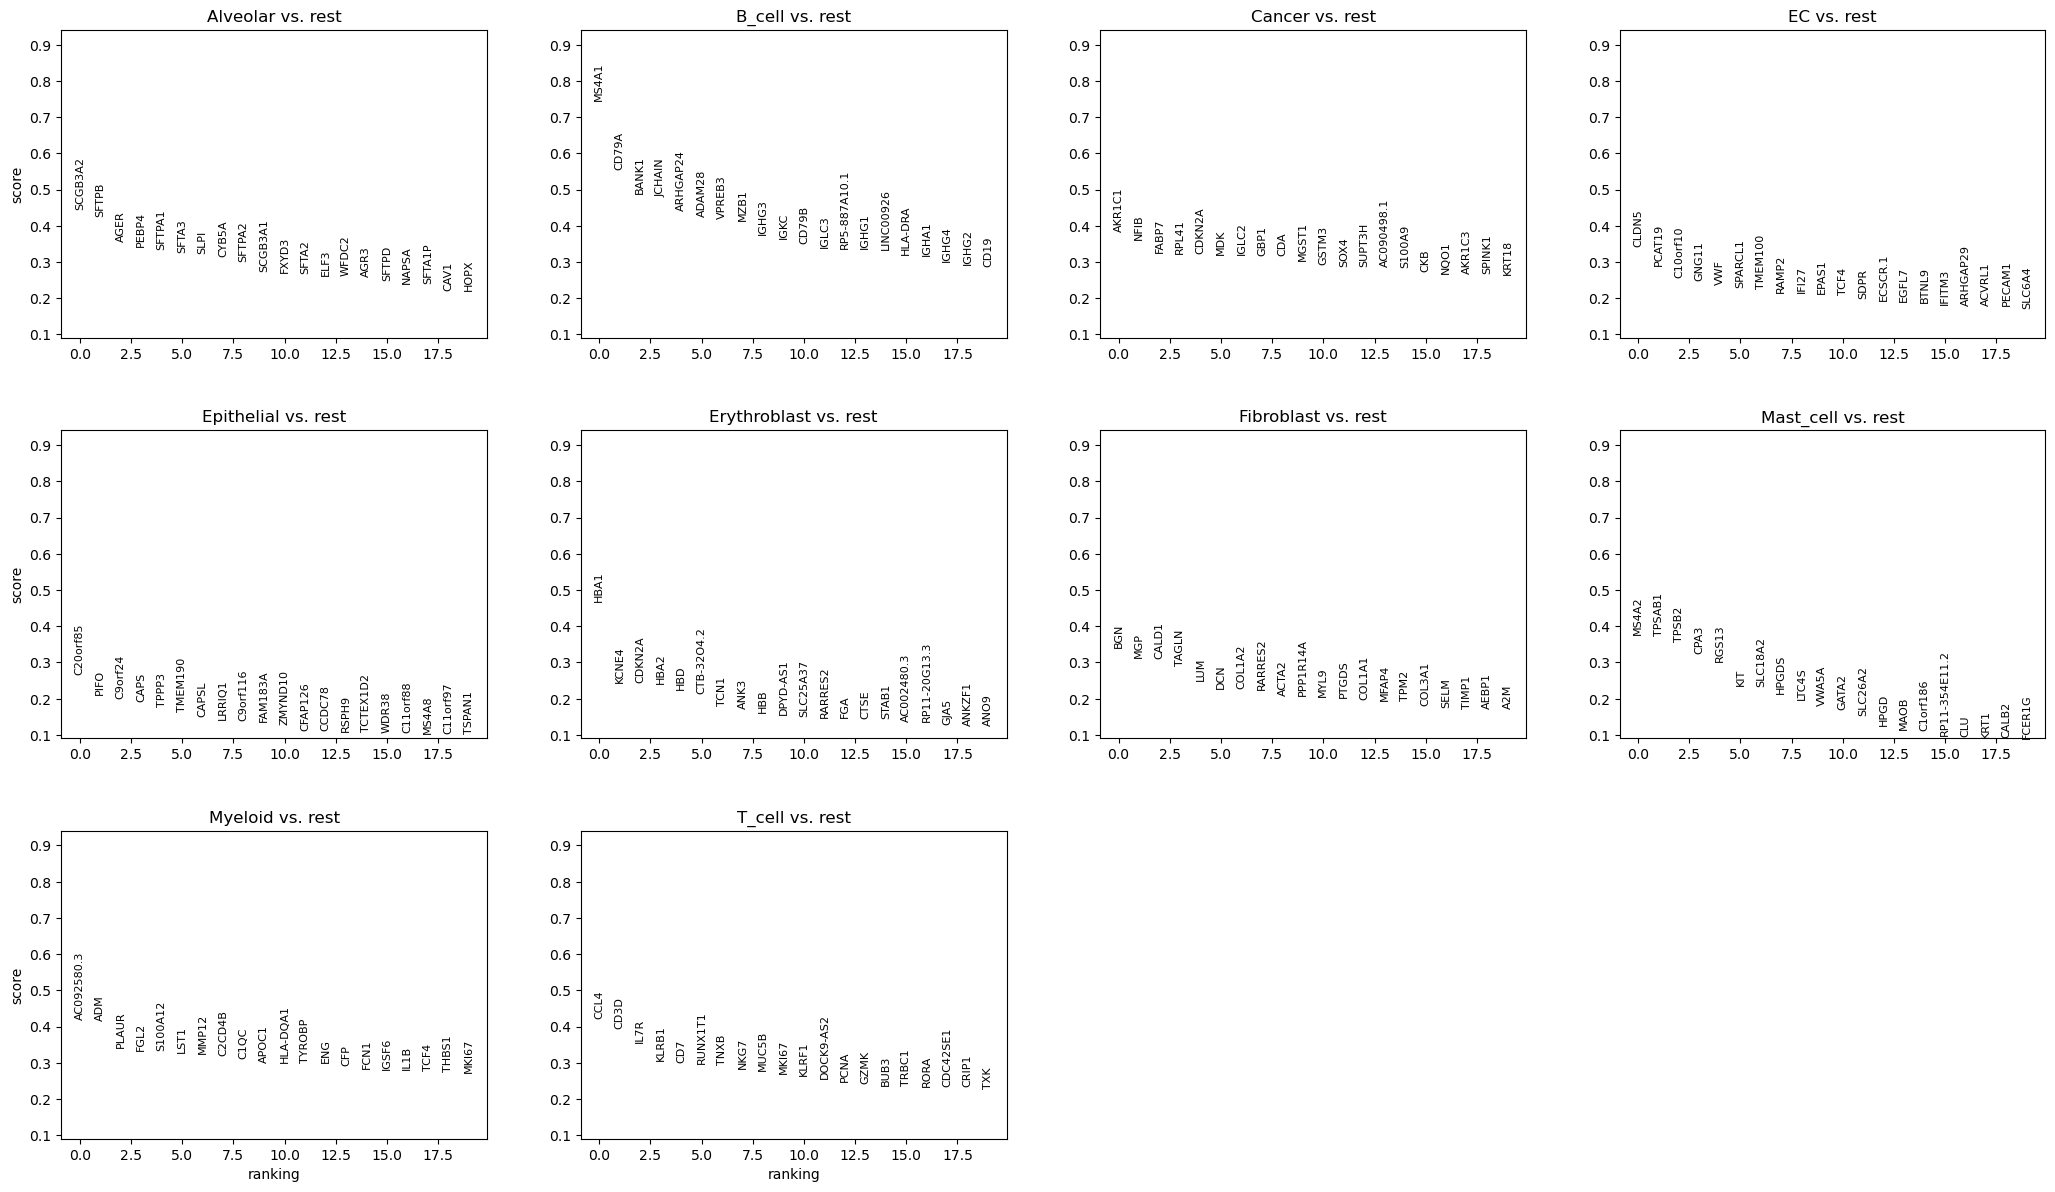

In [39]:
sc.pl.rank_genes_groups(adata)

In [40]:
post_time = time.time()

In [41]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 13.705354928970337


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [42]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

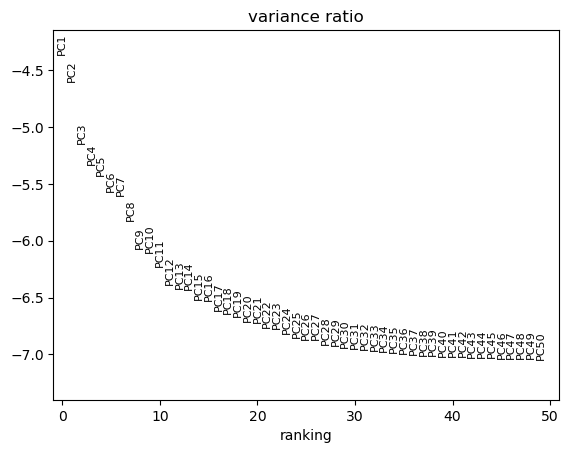

CPU times: user 836 ms, sys: 535 ms, total: 1.37 s
Wall time: 1.23 s


In [43]:
%%time
rsc.tl.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [44]:
%%time
rsc.tl.neighbors(tdata, n_neighbors=15, n_pcs=20)
rsc.tl.umap(tdata)
rsc.tl.louvain(tdata)

CPU times: user 328 ms, sys: 219 ms, total: 547 ms
Wall time: 547 ms


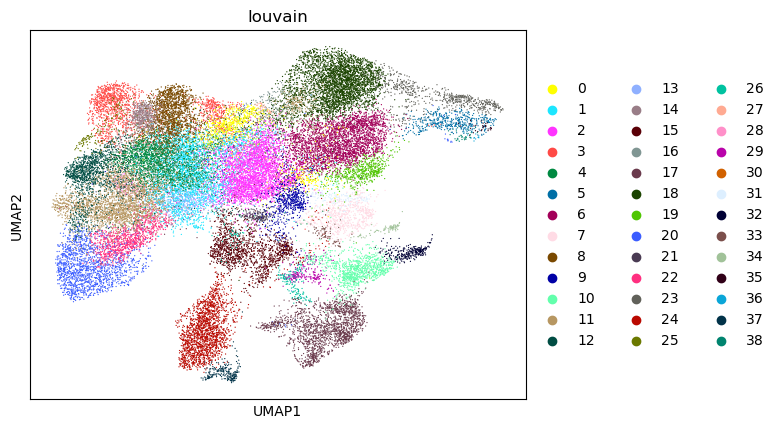

In [45]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis. To run the computation with cupy 9, you can use `scanpy_gpu_funcs` implementation.

In [46]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 97.5 ms, sys: 13.3 ms, total: 111 ms
Wall time: 110 ms


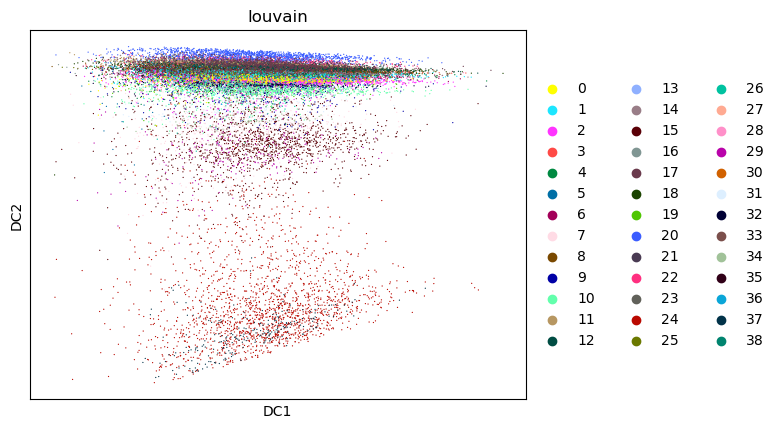

In [47]:
sc.pl.diffmap(tdata, color='louvain')

In [48]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 254 ms, sys: 17.7 ms, total: 272 ms
Wall time: 271 ms


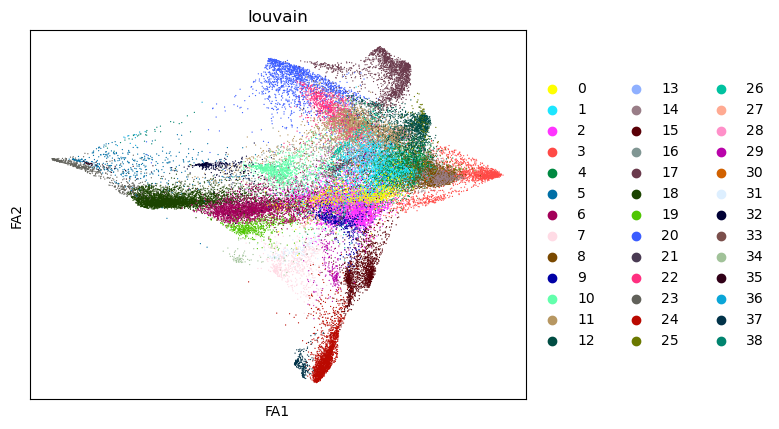

In [49]:
sc.pl.draw_graph(tdata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [50]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 22.35390877723694


## Decoupler-GPU

Here I introduce 2 functions of the `decoupler` package that have been accelerated with cupy: `mlm`and `wsum`.
You can use the same `nets` that you would use with the CPU implementation.

In [51]:
import decoupler as dc

In [52]:
net = dc.get_dorothea(organism='human', levels=['A','B','C'])

In [53]:
%%time
rsc.dcg.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True)

4 features of mat are empty, they will be removed.
Running mlm on mat with 91068 samples and 25656 targets for 297 sources.


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.83it/s]


CPU times: user 7.69 s, sys: 4.08 s, total: 11.8 s
Wall time: 11.8 s


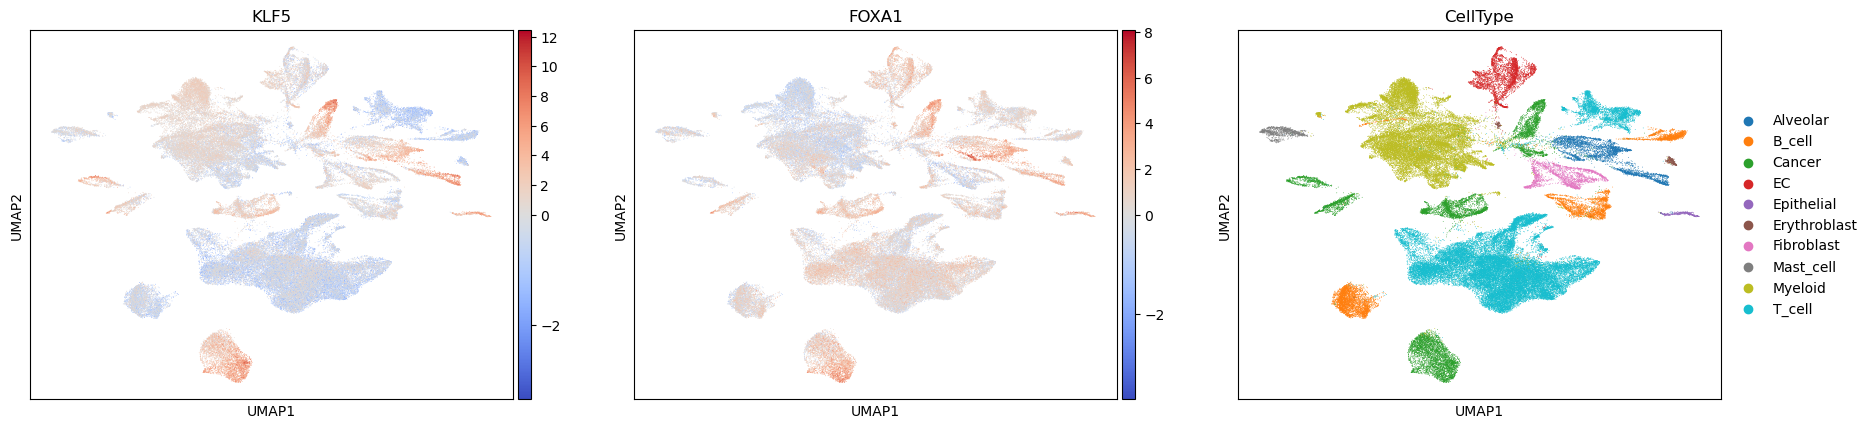

In [54]:
acts_mlm = dc.get_acts(adata, obsm_key='mlm_estimate')
sc.pl.umap(acts_mlm, color=['KLF5',"FOXA1", 'CellType'], cmap='coolwarm', vcenter=0)

In [55]:
model = dc.get_progeny(organism='human', top=100)

In [56]:
%%time
rsc.dcg.run_wsum(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

4 features of mat are empty, they will be removed.
Running wsum on mat with 91068 samples and 25656 targets for 14 sources.
Infering activities on 10 batches.


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.48s/it]

CPU times: user 1min 1s, sys: 44.4 s, total: 1min 46s
Wall time: 26.4 s


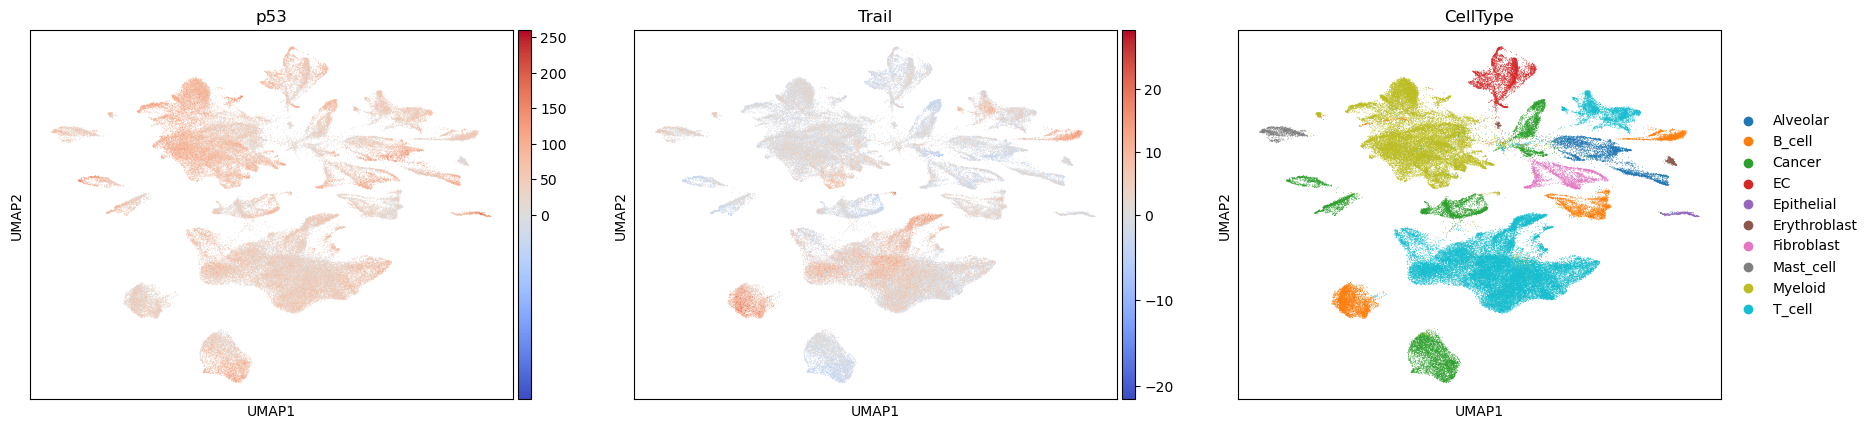

In [57]:
acts_wsum = dc.get_acts(adata, obsm_key='wsum_estimate')
sc.pl.umap(acts_wsum, color=['p53',"Trail", 'CellType'], cmap='coolwarm', vcenter=0)